# Prelude

In [1]:
from assyst.crystals import Formulas, sample_space_groups
from assyst.filters import DistanceFilter, AspectFilter, VolumeFilter
from assyst.relax import Relax, VolumeRelax, FullRelax, relax
from assyst.perturbations import RandomChoice, Rattle, Stretch, apply_perturbations

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from tqdm.auto import tqdm

In [5]:
import pickle

In [6]:
import matplotlib.pyplot as plt

## Options

In [7]:
# maximum number of atoms to generate for the training data
# 2 atoms is very low, chosen here only to keep the example fast
# 10 is a usual value, leading to ~10k structures in the final training data set
max_num = 2

In [8]:
!mkdir -p Unary/{max_num}

### Reference Potential

Simple example potential to have a fast reference to relax structures and generate training data.

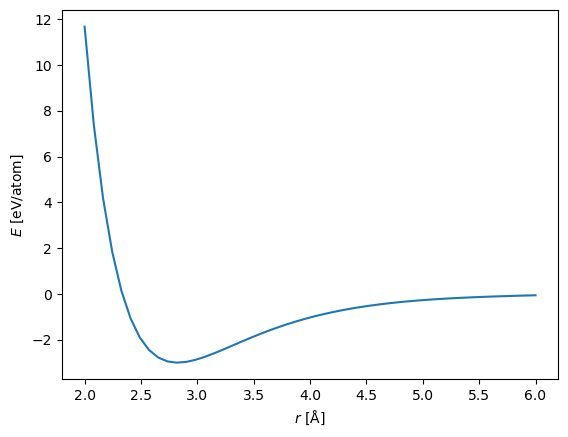

In [9]:
from ase.calculators.morse import MorsePotential

The values are chosen here so that they roughly reproduce Copper's lattice parameter.

In [10]:
reference = MorsePotential(epsilon=.3, r0=2.55265548*1.10619396, rho0=4)

Another good choice to play around with are the universal potentials based on the graph ACE models.

For this to work you'll need to install the `tensorpotential` PyPI package.

In [11]:
from assyst.calculators import Grace

In [12]:
Grace?

Init signature: Grace(model: str = 'GRACE-FS-OAM') -> None
Docstring:     
Universal Graph Atomic Cluster Expansion models.

.. attention::
    This class needs additional dependencies!
    Install `tensorpotential` from `PyPI <https://pypi.org/project/tensorpotential/>`__.
File:           ~/science/phd/dev/assyst/assyst/calculators.py
Type:           ABCMeta
Subclasses:     

# 1. Sampling Random Strucxtures

The first step in ASSYST: generation of random structures while prescribing all possible bulk symmetries.

In [13]:
fs = Formulas.range('Cu', max_num + 1)

In [14]:
fs

Formulas(atoms=({'Cu': 0}, {'Cu': 1}, {'Cu': 2}))

In [15]:
spg = list(filter(
    # without any constraints pyxtal sometimes generates strange unit cells, 
    # filter out any that have c/a > 6 as an empirical threshold
    AspectFilter(6), 
    sample_space_groups(
        fs, 
        # generate all possible space groups numbered from 1 to 230
        spacegroups=range(1,230+1), 
        max_atoms=max_num
    )
))

  0%|          | 0/3 [00:00<?, ?it/s]

Spacegroups:   0%|          | 0/230 [00:00<?, ?it/s]

Spacegroups:   0%|          | 0/230 [00:00<?, ?it/s]

In [16]:
len(spg)

167

## Save

In [17]:
with open(f"Unary/{max_num}/spg.pckl", 'bw') as f:
    pickle.dump(spg, f)

# 2. Relaxing Configurations

ASSYST seeks to find the important pockets in a materials' PES by applying a series of relaxation steps.
They can be specified by `Relax` and its subclasses.

In [18]:
ax.Relax?

Object `ax.Relax` not found.


In the ASSYST paper we use a volume relaxation and a full internal and cell shape relaxation step that I call here `VolMin` and `AllMin`.

In [19]:
volset = VolumeRelax(max_steps=100, force_tolerance=1e-3)

In [20]:
allset = FullRelax(max_steps=100, force_tolerance=1e-3)

Some more experimental relaxation settings are defined in `assyst.relax`, e.g. options to relax only the cell shape or placing constraints on the symmetry.

In practice, these relaxations are carried out using DFT with low convergence settings.  To speed up this example,
I use here a Morse Potential calculator from ASE, but interfaces to production quality DFT codes exist as well and could be dropped in here.

In [21]:
%%time
volmin = list(relax(volset, reference, tqdm(spg)))

  0%|          | 0/167 [00:00<?, ?it/s]

CPU times: user 2min 27s, sys: 134 ms, total: 2min 27s
Wall time: 49.5 s


In [22]:
allmin = list(relax(allset, reference, tqdm(volmin)))

  0%|          | 0/167 [00:00<?, ?it/s]

## Save

In [23]:
with open(f'Unary/{max_num}/volmin.pckl', 'wb') as f:
    pickle.dump(volmin, f)
with open(f'Unary/{max_num}/allmin.pckl', 'wb') as f:
    pickle.dump(allmin, f)

# 3. Random Perturbations

Final step in ASSYST: generating random configurations around the minima identified previously.

Apply the three types of random perturbations described in the ASSYST paper:
1. mostly positional noise with some cell changes
2. mostly hydrostatic cell changes
3. mostly shear cell changes

The later are combined to favour hydrostatic changes a bit more with `RandomChoice`.
The final list `mods` contains function-like objects that are applied to each fully minimized structure resulting from the previous steps.  `DistanceFilter` ensures that no structures contain atoms that are too close as a result of these modification.

In [24]:
rattle = Rattle(.25) + Stretch(hydro=.05, shear=0.005)
hydro = Stretch(hydro=.80, shear=.05)
shear = Stretch(hydro=.05, shear=.20)
stretch = RandomChoice(hydro, shear, .7)
mods = 4*[rattle] + 4*[stretch]

The settings above reproduce the so far published training sets, but may be optimized or played with.

In [25]:
%%time
random = list(apply_perturbations(allmin, mods, filters=[DistanceFilter({'Cu': 1})]))

CPU times: user 1.17 s, sys: 3.96 ms, total: 1.18 s
Wall time: 1.14 s


In [26]:
len(random)

1069

## Save

In [27]:
with open(f'Unary/{max_num}/random.pckl', 'wb') as f:
    pickle.dump(random, f)

# 4. Combine and Save Results

Load data from previous notebooks and evaluate cheap reference potential to construct
a simple training set.

In [28]:
with open(f'Unary/{max_num}/spg.pckl', 'rb') as f:
    spg = pickle.load(f)
with open(f'Unary/{max_num}/volmin.pckl', 'rb') as f:
    volmin = pickle.load(f)
with open(f'Unary/{max_num}/allmin.pckl', 'rb') as f:
    allmin = pickle.load(f)
with open(f'Unary/{max_num}/random.pckl', 'rb') as f:
    random = pickle.load(f)

Final filter step, removing structures with very close atoms or very large volumes.
In production runs, structures could also be filtered by forces or energy ranges.

In [29]:
everything = list(filter(VolumeFilter(300), filter(DistanceFilter({'Cu': 1}), spg + volmin + allmin + random)))

In [30]:
with open(f'Unary/{max_num}/everything.pckl', 'wb') as f:
    pickle.dump(everything, f)

# Fit a simple potential

Technically not part of the ASSYST workflow anymore, but now we have everything to train a (simple) potential.

In [44]:
df = []
for s in tqdm(everything):
    s.calc = reference
    df.append({
        'ase_atoms': s,
        'energy': s.get_potential_energy(),
        'forces': s.get_forces(),
        'number_of_atoms': len(s)
    })
df = pd.DataFrame(df)

  0%|          | 0/1460 [00:00<?, ?it/s]

In [45]:
df.to_pickle(f'Unary/{max_num}/everything_training_data.pckl.gz')

Text(0.5, 0, 'Energy per atom [eV/atom]')

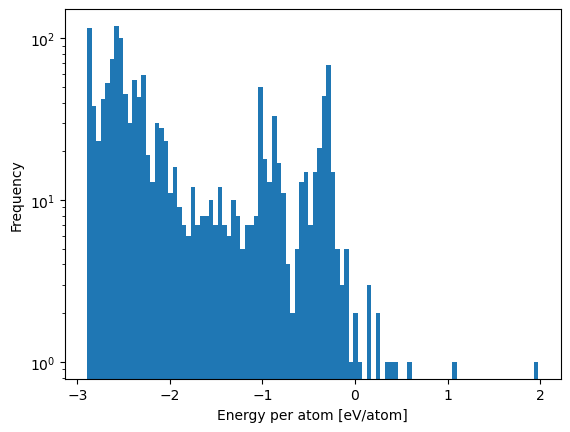

In [46]:
df.eval('energy/number_of_atoms').plot.hist(bins=100, log=True)
plt.xlabel('Energy per atom [eV/atom]')

(0.0, 300.0)

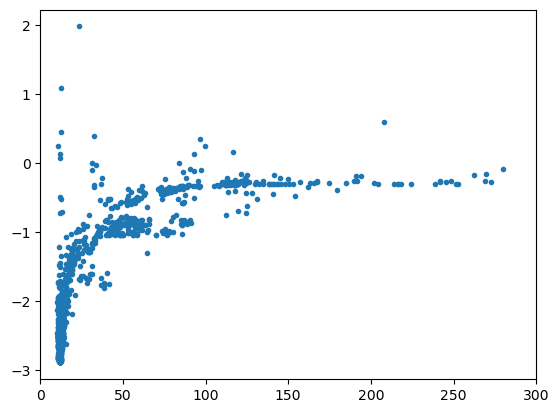

In [47]:
plt.scatter(df.ase_atoms.map(lambda s: s.cell.volume/len(s)), df.energy/df.number_of_atoms, marker='.')
plt.xlim(0, 300)

Text(0.5, 0, 'force components [eV/$\\mathrm{\\AA}$]')

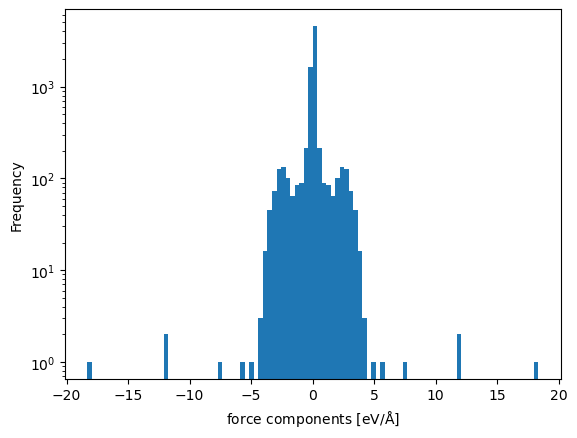

In [48]:
df.forces.explode().explode().infer_objects().plot.hist(bins=100, log=True)
plt.xlabel(r'force components [eV/$\mathrm{\AA}$]')

## Final Filtering Step

Because of the diverse and random nature of the structure in the training set, they can contain very extreme environments.
Those create undue difficulty for learning the potential without beeing very informative, because, e.g. they contain atoms at very close distances.
They can be filtered out either with `EnergyFilter` and `ForceFilter` when dealing with a list of Atoms, or directly on the pandas dataframe with the training data.

In [60]:
from assyst.filters import EnergyFilter, ForceFilter

In [61]:
EnergyFilter?

Init signature:
EnergyFilter(
    min_energy: float = -inf,
    max_energy: float = inf,
    *,
    missing: Literal['error', 'ignore'] = 'error',
) -> None
Docstring:      Filters structures by energy per atom.
File:           ~/science/phd/dev/assyst/assyst/filters.py
Type:           ABCMeta
Subclasses:     

In [62]:
ForceFilter?

Init signature:
ForceFilter(
    max_force: float = inf,
    *,
    missing: Literal['error', 'ignore'] = 'error',
) -> None
Docstring:      Filters structures by maximum force magnitude.
File:           ~/science/phd/dev/assyst/assyst/filters.py
Type:           ABCMeta
Subclasses:     

In [64]:
# filter(ForceFilter(10), ...)

These require ase `SinglePointCalculators` to be attached to the atoms.

Or working directly on pandas.

In [65]:
df.query('-3 <= energy / number_of_atoms < 10')

,ase_atoms,energy,forces,number_of_atoms,NUMBER_OF_ATOMS
0,"(Atom('Cu', [0.4904552729198183, 1.63243643194...",-2.557480,"[[1.54027859260511e-16, 8.817072997413392e-17,...",1,1
1,"(Atom('Cu', [1.1427851095528256, 0.04530252914...",-1.956908,"[[-3.2959746043559335e-17, 4.137315490204685e-...",1,1
2,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-1.980389,"[[9.280770596475918e-17, -1.249000902703301e-1...",1,1
3,"(Atom('Cu', [1.2374903121082077, 1.23749031210...",-1.740938,"[[-1.3742262536253769e-17, -3.309527131512002e...",1,1
4,"(Atom('Cu', [1.2952387291958223, 4.44089209850...",-2.092009,"[[3.361026734705064e-17, -1.0668549377257364e-...",1,1
...,...,...,...,...,...
1455,"(Atom('Cu', [0.12337953810948867, -0.035488792...",-5.226908,"[[2.274477532016276, -0.3575283070841724, -2.0...",2,2
1456,"(Atom('Cu', [0.1253714680968149, -0.0336145807...",-5.134857,"[[2.782709407024391, -0.23253255007378126, -2....",2,2
1457,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",-5.142435,"[[-2.624202938283915e-15, -1.366962099069724e-...",2,2
1458,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",-5.502145,"[[-2.3635607360183997e-15, -2.0929438737660178...",2,2


## ACE

Fit a simplified linear, pair descriptor only ACE potential to the training data.

You'll need to install `python-ace` from either PyPI or conda-forge.

In [49]:
import pyace.linearacefit as plf
import pyace
def make_ace(rmax, number_of_radial_functions, element='Cu'):
    '''Creates a simple basis configuration for a pair ACE.'''
    pot_conf = {
        'elements': [element],
        'embeddings': {
            'ALL': {
                'fs_parameters': [1, 1],
                'ndensity': 1,
                'npot': 'FinnisSinclair',
            },
        },
        'bonds': {
            'ALL': {
                'NameOfCutoffFunction': 'cos',
                'dcut': 0.01,
                'radbase': 'ChebPow',
                'radparameters': [2.0],
                'rcut': rmax
            },
        },
        'functions': {
            'UNARY': { 
                'nradmax_by_orders': [ number_of_radial_functions ],
                'lmax_by_orders':    [  0 ] 
            }
        }
    }
    return pyace.create_multispecies_basis_config(pot_conf)

/home/ponder/micromamba/envs/assyst/lib/python3.11/site-packages/pyace/multispecies_basisextension.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [50]:
from ase import Atoms
def dimer(calc, r):
    '''Helper function to evaluate a dimer curve for a given calculator.

    Args:
        calc (ase.calculator.Calculator): the potential to evaluate
        r (iterable of float): distances to evaluate the dimer curve at

    Returns:
        array of distances as given, array of corresponding energies.'''
    s = lambda r: Atoms(['Cu','Cu'], positions=[[0.]*3, [r, 0, 0]], cell=[40]*3)
    e = []
    r = np.array(r)
    for ri in r:
        si = s(ri)
        si.calc = calc
        e.append(si.get_potential_energy())
    return r, np.array(e)

In [51]:
bbasis = make_ace(6.5, number_of_radial_functions=20, element='Cu')
ds = plf.LinearACEDataset(bbasis, df)

In [52]:
%%time
ds.construct_design_matrix()

CPU times: user 6.69 ms, sys: 61.1 ms, total: 67.8 ms
Wall time: 898 ms


In [53]:
lf = plf.LinearACEFit(train_dataset=ds)

In [54]:
%%time
lf.fit()

CPU times: user 4.96 ms, sys: 1.98 ms, total: 6.94 ms
Wall time: 11.4 ms


,alpha,1e-05
,fit_intercept,False
,copy_X,False
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


In [55]:
acef = pyace.PyACECalculator(lf.get_bbasis())

Basic error metrics.

In [56]:
lf.compute_errors()

{'epa_mae': 0.0031517361621489818,
 'epa_rmse': 0.00443638735345121,
 'f_comp_mae': 0.0015019558016016387,
 'f_comp_rmse': 0.0033168030199981578}

Compare the resulting pair potential.

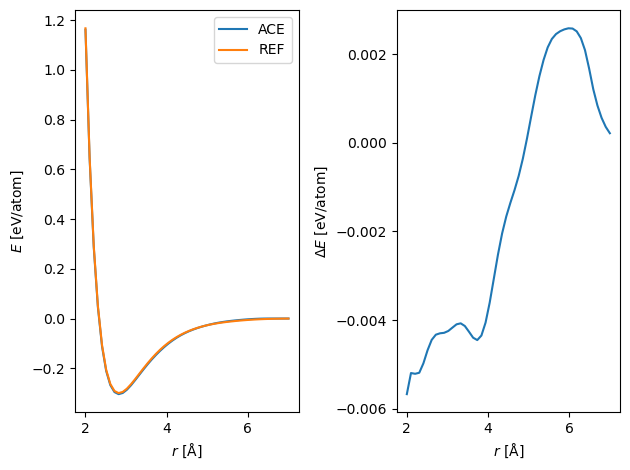

In [57]:
r = np.linspace(2, 7)
plt.subplot(121)
plt.plot(*dimer(acef, r),  label='ACE')
plt.plot(*dimer(reference, r), label='REF')
plt.legend()
plt.xlabel(r'$r$ [$\mathrm{\AA}$]')
plt.ylabel(r'$E$ [eV/atom]')
plt.subplot(122)
plt.plot(r, dimer(acef, r)[1]-dimer(reference, r)[1])
plt.xlabel(r'$r$ [$\mathrm{\AA}$]')
plt.ylabel(r'$\Delta E$ [eV/atom]')
plt.tight_layout()